In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from collections import Counter

In [21]:
def entropy(y):
    count = Counter(y)
    total = len(y)
    if total == 0:
        return 0
    return -sum((count[c] / total) * np.log2(count[c] / total) for c in count)


def split_info(X, feature_idx):
    values, counts = np.unique(X[:, feature_idx], return_counts=True)
    total = len(X)
    if total == 0:
        return 0
    proportions = counts / total
    return -np.sum(proportions * np.log2(proportions))


def information_gain(X, y, feature_idx):
    total_entropy = entropy(y)
    
    values = np.unique(X[:, feature_idx])
    weighted_entropy = 0
    
    for value in values:
        subset_idx = (X[:, feature_idx] == value)
        y_subset = y[subset_idx]
        weighted_entropy += (len(y_subset) / len(y)) * entropy(y_subset)
    
    return total_entropy - weighted_entropy


def gain_ratio(X, y, feature_idx):
    gain = information_gain(X, y, feature_idx)
    split_i = split_info(X, feature_idx)
    
    if split_i == 0:
        return 0
        
    return gain / split_i


def build_tree(X, y, features=None, criterion='gain_ratio'):
    if len(np.unique(y)) == 1:
        return {'class': y[0]}
        
    if X.shape[1] == 0:
        return {'class': Counter(y).most_common(1)[0][0]}
        
    if features is None:
        features = list(range(X.shape[1]))
        
    best_feature = None
    best_score = -1
    
    for feature_idx in features:
        score = gain_ratio(X, y, feature_idx)
           
        if score > best_score:
            best_score = score
            best_feature = feature_idx

    if best_feature is None:
        return {'class': Counter(y).most_common(1)[0][0]}
        
    tree = {'feature': best_feature}
    tree['branches'] = {}
    
    feature_values = np.unique(X[:, best_feature])
    
    for value in feature_values:
        subset_idx = (X[:, best_feature] == value)
        X_subset = X[subset_idx]
        y_subset = y[subset_idx]
        tree['branches'][value] = build_tree(X_subset, y_subset, [f for f in features if f != best_feature])
   
    return tree


def predict(tree, x):
    if 'class' in tree:
        return tree['class']
        
    feature_value = x[tree['feature']]
    if feature_value not in tree['branches']:
        return max(
            (predict(subtree, x) 
             for subtree in tree['branches'].values()),
            key=lambda x: sum(1 for t in tree['branches'].values() 
                            if 'class' in t and t['class'] == x)
        )
    return predict(tree['branches'][feature_value], x)

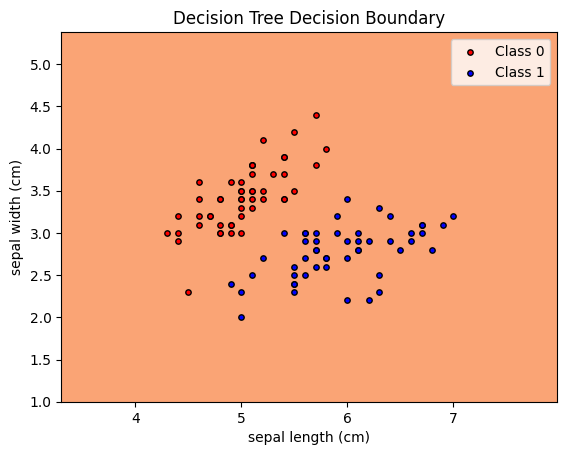

In [23]:
iris = load_iris()
X = iris.data
y = iris.target

binary_data = y != 2
X_binary = X[binary_data]
y_binary = y[binary_data]
y_binary = np.where(y_binary == 0, 0, 1)

Tree = build_tree(X_binary, y_binary)

predictions = [predict(Tree, x) for x in X_binary]

x_min, x_max = X_binary[:, 0].min() - 1, X_binary[:, 0].max() + 1
y_min, y_max = X_binary[:, 1].min() - 1, X_binary[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))


Z = [predict(tree, [xx.ravel()[i], yy.ravel()[i], 0, 0]) for i in range(len(xx.ravel()))]  # We only use the first two features
Z = np.array(Z).reshape(xx.shape)


plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)


for i, color in zip(range(2), ['red', 'blue']):
    idx = np.where(y_binary == i)
    plt.scatter(X_binary[idx, 0], X_binary[idx, 1], c=color, label=f"Class {i}", edgecolor="black", s=15)

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Decision Tree Decision Boundary")
plt.legend()
plt.show()